In [1]:
from frame_postprocess import *

set_plot_formatting()
color_specs = ['tab:red','tab:green','tab:orange','tab:purple','tab:olive'] #

#### INPUTS

Building geometry and relevant properties

In [2]:
bldg_name  = 'inputs_8storyFrameOakland'
cvn = 12

result_list = [os.path.join('..','OUTPUTS','PUSHOVER', 'Output')]
sf = 1.0
dt = 0.0050

##### Frame direction #####
n_stories = 3

## Retrieve inputs for plots ##
cvn           = 'ASCE41'  # ft-lb
a0            = 0.1
distribution  = 'Constant'
splice        = 0

story_heights = np.ones(8)*156
beam_list   = np.ones((8,4))
column_list = np.ones((8,5))
bay_widths  = np.ones(4)*300
n_bays      = len(bay_widths) 
n_stories   = len(story_heights)

#### COLLECT RESULTS FROM NLRHA

In [3]:
story_response = {}
column_response = {}
frac_simulated = {}
FI_simulated = {}
beam_plas_rot = {}
pz_response = {}

for model_i, results_folder in enumerate(result_list):
    
    print(results_folder)
    
    story_response[results_folder]  = get_story_response(results_folder, beam_list, ['disp'])
    res_type='all_t'

    pz_response[results_folder]     = get_pz_response_time(results_folder, beam_list, column_list, ['all_disp', 'pz_rot'], res_type)
    
    if cvn != 'ASCE41':
        beam_plas_rot   = get_beam_response(results_folder, beam_list, ['hinge_left','hinge_right'])
        column_response[results_folder] = get_column_response_time(results_folder, beam_list, column_list, ['hinge_bot','hinge_top'], res_type)
        beam_plas_rot[results_folder]   = get_beam_response_time(results_folder, beam_list, ['hinge_left','hinge_right'], res_type)
        frac_simulated[results_folder]  = get_beam_response_time(results_folder, beam_list, ['frac_LB','frac_LT','frac_RB','frac_RT'], res_type)
        FI_simulated[results_folder]    = get_beam_response_time(results_folder, beam_list, ['FI_LB','FI_LT','FI_RB','FI_RT'], res_type)
    else:
        beam_plas_rot[results_folder]   = get_beam_response_time(results_folder, beam_list, ['hinge_left','hinge_right'], res_type)
        column_response[results_folder] = get_column_response_time(results_folder, beam_list, column_list, ['hinge_bot','hinge_top'], res_type)
   
    

..\OUTPUTS\PUSHOVER\Output


#### PLOT COLLAPSE MECHANISM

..\OUTPUTS\PUSHOVER\Output


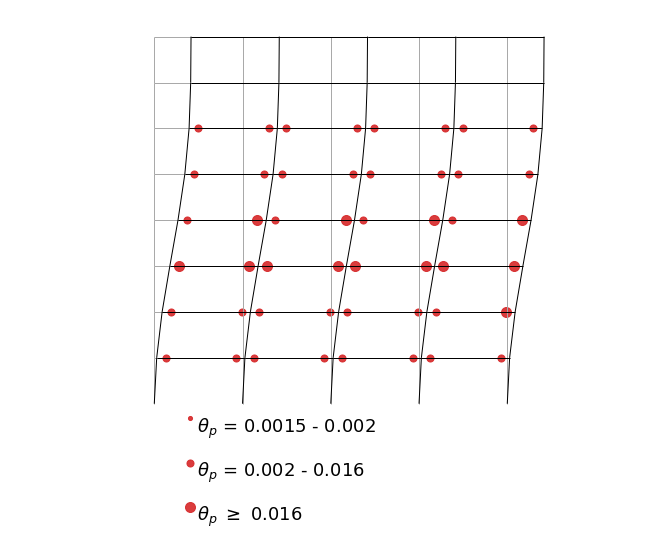

In [8]:
marker_size = 100 # size marker for fractures

# fig, ax_list = plt.subplots(2,int(len(cvn_list)/2), figsize=(8,8))  
fig, ax = plt.subplots(1,len(result_list), figsize=(14,8))

# element coordinates
plot_scale = 10
n_stories, n_bays, columns, beams, joints_x, joints_y = get_coordinates(beam_list, column_list, bay_widths, story_heights)
edp = np.zeros([n_stories, 1])
t = -1

# Buildings per simulation
for model_i, results_folder in enumerate(result_list):
    
    # results folder name
    edp = pz_response[results_folder]['all_disp'] #story_response[results_folder]['disp']
    
    # Adjust EDP if there are beams extending two bays
    if edp.ndim == 3:
        edp = edp[:, :, t]
        
    n_floors, n_piers = edp.shape
    n_stories = n_floors - 1
    n_bays = n_piers - 1
    for i_story in range(n_stories):
        for i_bay in range(n_bays):
            if (beam_list[i_story, min(i_bay + 1, n_bays - 1)] == 0) and \
                    (column_list[i_story, min(i_bay + 1, n_bays)] == 0) and \
                    (column_list[min(i_story + 1, n_stories - 1), min(i_bay + 1, n_bays)] == 0):
                # for double bay beams
#                 print(edp[i_story+1, i_bay + 2])
                edp[i_story+1, min(i_bay + 1, n_bays)] = edp[i_story+1, i_bay+2] 
    
    print(results_folder)
    plot_building_at_t(t, edp, columns, beams, plot_scale, column_list, beam_list, ax, x_gap=500)    
    
    # Plot building response shape
    if cvn == 'ASCE41':
        plot_beam_response_bins_edp(ax, t, edp, joints_x, joints_y, np.abs(beam_plas_rot[results_folder]['hinge_left']), 
                                    np.abs(beam_plas_rot[results_folder]['hinge_right']), labelText='$\\theta_p$', plot_scale=plot_scale,
                               max_marker_size=marker_size, bins=np.array([0, 0.0015, 0.002, 0.016]), edgecolor=color_specs[model_i], 
                                facecolors=color_specs[model_i], addLegend=True)
        plot_column_response_bins_edp(ax, t, edp, joints_x, joints_y, np.abs(column_response[results_folder]['hinge_bot']), 
                                np.abs(column_response[results_folder]['hinge_top']), labelText='$\\theta_p$', plot_scale=plot_scale,
                               max_marker_size=marker_size, bins=np.array([0, 0.0025, 0.01, 0.01]), edgecolor='grey', 
                                facecolors='grey', addLegend=False)
        plot_column_response_bins_edp(ax, t, edp, joints_x, joints_y, np.zeros(column_list.shape), 
                                      np.max(np.abs(pz_response[results_folder]['pz_rot']),axis=2), d_y=0, max_value=1, 
                              max_marker_size=marker_size, plot_scale=plot_scale, 
                              labelText='$\\theta_p$', bins=np.array([0, 0.003, 0.01, 0.02]), addLegend=False)
    else:
        plot_fractures_edp(ax, t, edp, joints_x, joints_y, frac_simulated[results_folder], plot_scale=plot_scale, marker_size=marker_size,
                          one_fracture_color=color_specs[model_i], both_fractures_color='k')
        plot_beam_response_bins_edp(ax, t, edp, joints_x, joints_y, np.abs(beam_plas_rot[results_folder]['hinge_left']), 
                                    np.abs(beam_plas_rot[results_folder]['hinge_right']), labelText='$\\theta_p$', plot_scale=plot_scale,
                               max_marker_size=marker_size, bins=np.array([0, 0.0025, 0.01, 0.02]), edgecolor='grey', 
                                facecolors='grey', addLegend=False)
        plot_column_response_bins_edp(ax, t, edp, joints_x, joints_y, np.abs(column_response[results_folder]['hinge_bot']), 
                                np.abs(column_response[results_folder]['hinge_top']), labelText='$\\theta_p$', plot_scale=plot_scale,
                               max_marker_size=marker_size, bins=np.array([0, 0.0025, 0.01, 0.02]), edgecolor='grey', 
                                facecolors='grey', addLegend=False)
        plot_column_response_bins_edp(ax, t, edp, joints_x, joints_y, np.zeros(column_list.shape), 
                                      np.max(np.abs(pz_response[results_folder]['pz_rot']),axis=2), d_y=0, max_value=1, 
                              max_marker_size=marker_size, plot_scale=plot_scale, 
                              labelText='$\\theta_p$', bins=np.array([0, 0.003, 0.01, 0.02]), addLegend=False)


plt.tight_layout()



#### DRIFT PROFILE

In [5]:
disp_max = np.max(story_response[results_folder]['disp'],1)
drift = []
for i in range(len(disp_max)):
    if i == 0:
        drift.append(disp_max[i]/story_heights[i])
    else:
        drift.append((disp_max[i]-disp_max[i-1])/story_heights[i])
drift = np.array(drift).reshape(-1,1)

total time = 0.04152408010953092s


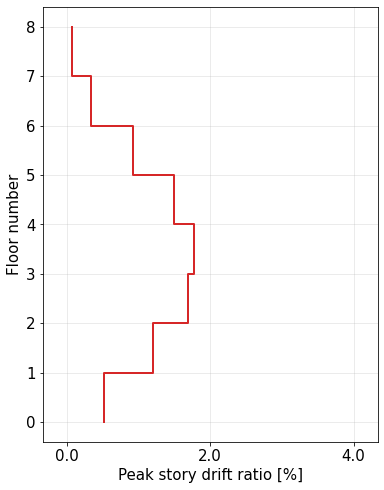

In [6]:
x_ticks = np.array([0, 2.0, 4.0])

# Peak drift profile
fig, ax = plt.subplots(1,1, figsize=(6,8)) 

legend_text = []
for model_i, results_folder in enumerate(result_list):
    
    print('total time = ' + str(pz_response[results_folder]['time'][-1]) + 's')
    
    plot_story_response(ax, drift, story_heights, bay_widths, 
                        color_name=color_specs[model_i], x_ticks=x_ticks)
    

    legend_text.append(results_folder)
    
# _ = ax.legend(legend_text)#,bbox_to_anchor=(1.05, 1), loc='best')

In [7]:
print('\nBOTTOM HINGE ROTATION')
np.max(np.abs(column_response[results_folder]['hinge_bot']), axis=2)
print('\nTOP HINGE ROTATION')
np.max(np.abs(column_response[results_folder]['hinge_top']), axis=2)

print('\nLEFT HINGE ROTATION')
np.max(np.abs(beam_plas_rot[results_folder]['hinge_left']), axis=2)
print('\nRIGHT HINGE ROTATION')
np.max(np.abs(beam_plas_rot[results_folder]['hinge_right']), axis=2)


BOTTOM HINGE ROTATION


array([[1.4510824e-04, 1.1280755e-04, 1.9203666e-04, 3.1289069e-05,
        4.3298422e-05],
       [6.6917589e-05, 9.7717359e-05, 1.9320788e-04, 3.1702406e-05,
        4.3021320e-05],
       [1.5764934e-04, 1.7512234e-04, 1.9538489e-04, 5.9398873e-05,
        8.3398903e-05],
       [6.0505572e-05, 1.9768630e-04, 1.4565050e-04, 5.9503957e-05,
        9.1587077e-06],
       [1.5805035e-04, 1.9593327e-04, 6.8852787e-05, 6.0532588e-05,
        1.4251678e-05],
       [6.1050451e-05, 1.9318195e-04, 7.1102197e-05, 6.9602089e-05,
        2.0353950e-05],
       [1.5761303e-04, 1.6978430e-04, 7.0955380e-05, 7.6776699e-05,
        2.3079959e-05],
       [6.1607087e-05, 1.6004494e-04, 7.1161857e-05, 4.3152436e-05,
        1.7051737e-05]])


TOP HINGE ROTATION


array([[3.4632108e-05, 3.1878227e-05, 6.5095056e-05, 6.1116890e-05,
        1.2881726e-04],
       [1.4270227e-04, 1.2683080e-04, 6.5134923e-05, 1.4133400e-04,
        1.2892074e-04],
       [6.3253846e-05, 8.5466027e-05, 6.5938504e-05, 1.5903898e-04,
        8.8451104e-05],
       [1.6515461e-04, 5.7234459e-05, 9.2567422e-05, 1.5975084e-04,
        1.5259530e-05],
       [6.3417495e-05, 5.7234715e-05, 9.6785538e-05, 1.6021156e-04,
        3.0410074e-05],
       [1.6549088e-04, 5.6866252e-05, 1.0430723e-04, 1.2281795e-04,
        3.6998682e-05],
       [6.3310252e-05, 8.6062597e-05, 1.0506300e-04, 1.0293971e-04,
        3.9743153e-05],
       [1.6536158e-04, 5.1017486e-05, 1.0573629e-04, 1.2982742e-04,
        1.8985969e-05]])


LEFT HINGE ROTATION


array([[6.82987222e-03, 6.23801454e-03, 6.22441316e-03, 6.23485277e-03],
       [1.23826648e-02, 1.29884286e-02, 1.30248175e-02, 1.31007672e-02],
       [1.64677900e-02, 1.66951497e-02, 1.67154935e-02, 1.67711561e-02],
       [1.55935002e-02, 1.59103569e-02, 1.59219644e-02, 1.59909896e-02],
       [1.13632093e-02, 1.17616873e-02, 1.17813928e-02, 1.18367983e-02],
       [5.62771563e-03, 5.43308756e-03, 5.42788213e-03, 5.48002684e-03],
       [6.24959258e-05, 6.36626215e-05, 6.47147544e-05, 1.03855104e-04],
       [1.03501434e-05, 2.15762134e-05, 1.54794592e-05, 2.22570707e-05]])


RIGHT HINGE ROTATION


array([[6.73509260e-03, 6.75494604e-03, 6.74273604e-03, 7.32334926e-03],
       [1.57118013e-02, 1.58629824e-02, 1.59101886e-02, 1.67529933e-02],
       [1.88674689e-02, 1.90280986e-02, 1.90481196e-02, 1.96674859e-02],
       [1.80194927e-02, 1.82054852e-02, 1.82262839e-02, 1.90310879e-02],
       [1.34964848e-02, 1.37278421e-02, 1.37422929e-02, 1.42442662e-02],
       [5.62898051e-03, 5.83195127e-03, 5.83481691e-03, 6.33934361e-03],
       [5.51879569e-05, 3.03121137e-04, 3.22388178e-04, 8.45852492e-04],
       [5.90145702e-06, 1.83490621e-05, 1.39542500e-05, 2.84895906e-05]])